In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import category_encoders as ce

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import mannwhitneyu

import pingouin as pg

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve

C:\Users\johan\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.3.9.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
titanic = pd.read_csv('titanic_train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


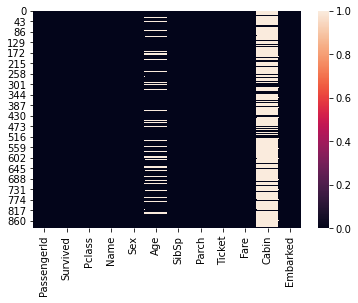

In [3]:
sns.heatmap(titanic.isna())
plt.show()

In [4]:
titanic.isna().sum()/len(titanic)*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [5]:
titanic['Cabin'].value_counts(dropna=False)

NaN            687
C23 C25 C27      4
B96 B98          4
G6               4
F33              3
              ... 
C103             1
B86              1
A36              1
E31              1
C110             1
Name: Cabin, Length: 148, dtype: int64

In [6]:
titanic.columns = titanic.columns.str.lower()

In [7]:
titanic.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [8]:
titanic.drop(['cabin', 'passengerid', 'ticket'], axis=1, inplace=True)

## __FEATURE ENGINEERING__

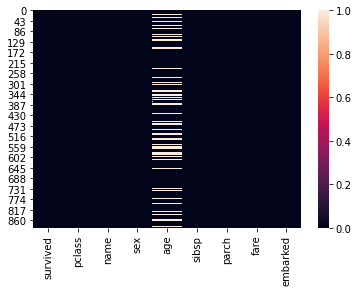

In [9]:
sns.heatmap(titanic.isna())
plt.show()

## __AGE__

C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


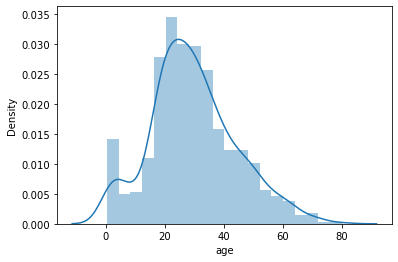

In [10]:
sns.distplot(titanic.age)
plt.show()

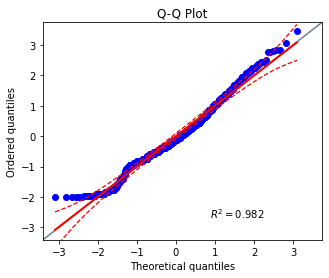

In [11]:
pg.qqplot(titanic.age, dist='norm')

## __EMBARKED__

In [12]:
titanic.embarked.value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [13]:
titanic[titanic['embarked'].isna() == True]

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


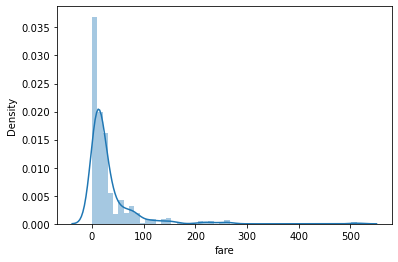

In [14]:
sns.distplot(titanic.fare)

In [15]:
pd.crosstab(index=titanic.embarked, columns=titanic.pclass, values=titanic.fare, aggfunc=np.median)

pclass,1,2,3
embarked,,,
C,78.2667,24.00,7.8958
Q,90.0000,12.35,7.7500
S,52.0000,13.50,8.0500


In [16]:
pd.crosstab(index=titanic.embarked, columns=titanic.sex, normalize=1)

sex,female,male
embarked,,
C,0.233974,0.164645
Q,0.115385,0.071057
S,0.650641,0.764298


- Age impute with mean
- Embarked impute with S

## __NAME__

In [17]:
titanic['title'] = titanic['name'].str.split(',').str[1].str.split('.').str[0]
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [18]:
titanic.name.nunique()

891

In [19]:
titanic.title.nunique()

17

## __EDA__

In [20]:
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr


In [21]:
titanic.drop(['name'], axis=1, inplace=True)

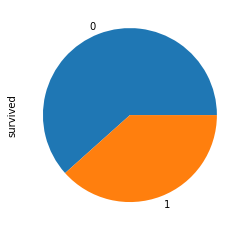

In [22]:
titanic.survived.value_counts(normalize=True).plot(kind='pie')
plt.show()

C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


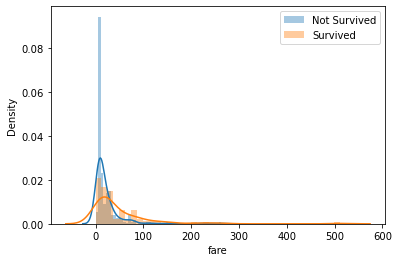

In [23]:
sns.distplot(titanic[titanic['survived'] == 0]['fare'], label='Not Survived')
sns.distplot(titanic[titanic['survived'] == 1]['fare'], label='Survived')
plt.legend()
plt.show()

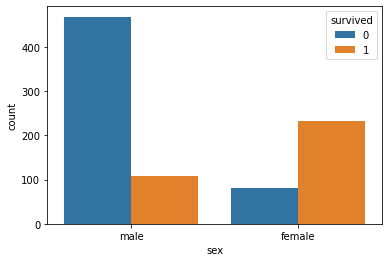

In [24]:
sns.countplot(x='sex', hue='survived', data=titanic)
plt.show()

In [25]:
pd.crosstab(index=titanic['sex'], columns=titanic['survived'], normalize=0)

survived,0,1
sex,,
female,0.257962,0.742038
male,0.811092,0.188908


C:\Users\johan\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 71.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 48.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


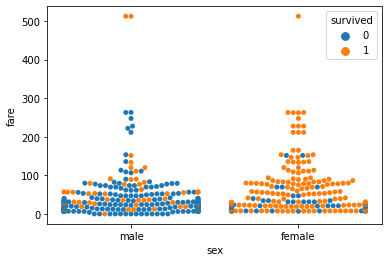

In [26]:
sns.swarmplot(y="fare", x="sex", hue="survived", data=titanic)
plt.show()

In [27]:
titanic['sibsp'].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

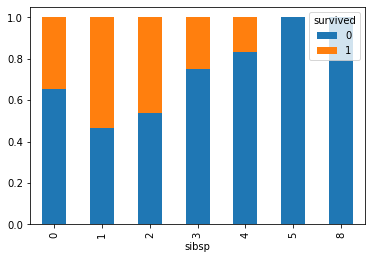

In [28]:
pd.crosstab(titanic['sibsp'], titanic['survived'], normalize=0).plot(kind='bar', stacked=True)

In [29]:
pd.crosstab(titanic['sibsp'], titanic['survived'], normalize=0)

survived,0,1
sibsp,,
0,0.654605,0.345395
1,0.464115,0.535885
2,0.535714,0.464286
3,0.750000,0.250000
4,0.833333,0.166667
5,1.000000,0.000000
8,1.000000,0.000000


In [30]:
titanic[titanic['sibsp'] == 8]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
159,0,3,male,NaN,8,2,69.55,S,Master
180,0,3,female,NaN,8,2,69.55,S,Miss
201,0,3,male,NaN,8,2,69.55,S,Mr
324,0,3,male,NaN,8,2,69.55,S,Mr
792,0,3,female,NaN,8,2,69.55,S,Miss
846,0,3,male,NaN,8,2,69.55,S,Mr
863,0,3,female,NaN,8,2,69.55,S,Miss


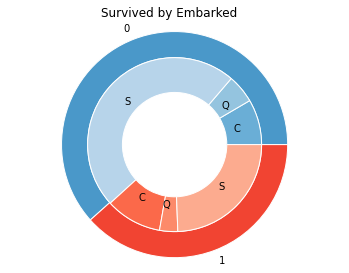

In [31]:
by_embarked = titanic.groupby('embarked')['survived'].value_counts().to_frame().rename(columns={'survived': 'freq'}).reset_index().sort_values('survived')

# Make data: I have 2 groups and 3 subgroups
group_names=titanic['survived'].value_counts().index
group_size=titanic['survived'].value_counts()
subgroup_names=by_embarked['embarked']
subgroup_size=by_embarked['freq']
 
# Create colors
a, b, c = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
 
# First Ring (outside)
fig, ax = plt.subplots()
fig.suptitle('Survived by Embarked')
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6)])
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), b(0.3)])
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

In [32]:
pd.crosstab(index=titanic['embarked'], columns=titanic['survived'], normalize=1)

survived,0,1
embarked,,
C,0.136612,0.273529
Q,0.085610,0.088235
S,0.777778,0.638235


In [33]:
titanic[titanic['embarked'] == 'S']['pclass'].value_counts()

3    353
2    164
1    127
Name: pclass, dtype: int64

C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

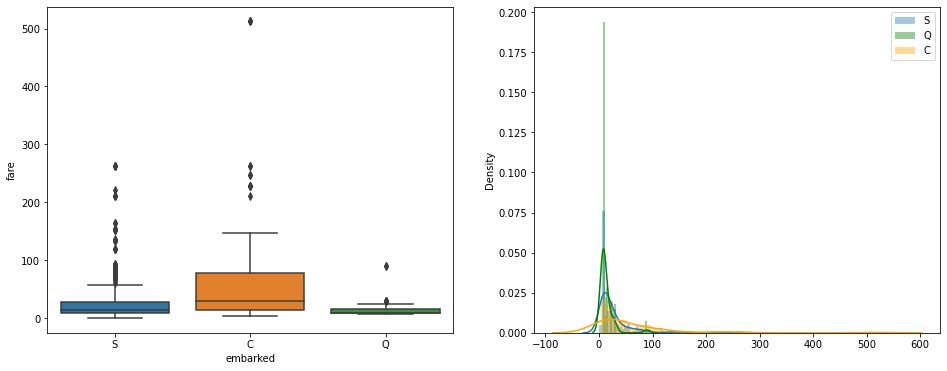

In [34]:
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.boxplot(x='embarked', y='fare', data=titanic)

plt.subplot(122)
sns.distplot(x=titanic[titanic['embarked'] == 'S']['fare'], label='S')
sns.distplot(x=titanic[titanic['embarked'] == 'Q']['fare'], label='Q', color='green')
sns.distplot(x=titanic[titanic['embarked'] == 'C']['fare'], label='C', color='orange')

plt.legend()
plt.show()

In [35]:
stats, p = mannwhitneyu(titanic[titanic['embarked'] == 'S']['fare'], titanic[titanic['embarked'] == 'C']['fare'], alternative='less')

if p < 0.05:
    print('Southampton median fare are less than Cherbourg')
else:
    print('Southampton median fare are equal to Cherbourg')

Southampton median fare are less than Cherbourg


In [36]:
stats, p = mannwhitneyu(titanic[titanic['embarked'] == 'S']['fare'], titanic[titanic['embarked'] == 'Q']['fare'], alternative='less')

if p < 0.05:
    print('Southampton median fare are less than Queenstown')
else:
    print('Southampton median fare are equal to Queenstown')

Southampton median fare are equal to Queenstown


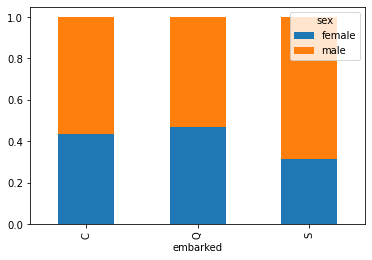

In [37]:
pd.crosstab(index=titanic['embarked'], columns=titanic['sex'], normalize=0).plot(kind='bar', stacked=True)

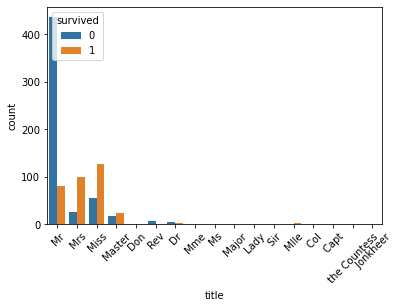

In [38]:
sns.countplot(x='title', hue='survived', data=titanic)
plt.xticks(rotation=45)
plt.show()

In [39]:
pd.crosstab(index=titanic['title'], columns=titanic['survived'], normalize=0).sort_values(0, ascending=False)

survived,0,1
title,,
Capt,1.000000,0.000000
Don,1.000000,0.000000
Jonkheer,1.000000,0.000000
Rev,1.000000,0.000000
Mr,0.843327,0.156673
Dr,0.571429,0.428571
Major,0.500000,0.500000
Col,0.500000,0.500000
Master,0.425000,0.575000


## __MODELLING__

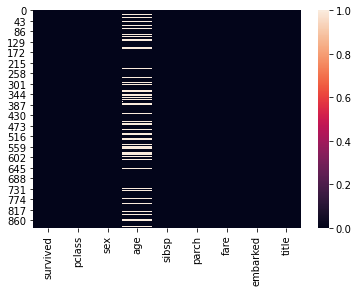

In [40]:
sns.heatmap(titanic.isna())

In [41]:
titanic.isna().sum()/len(titanic)*100

survived     0.000000
pclass       0.000000
sex          0.000000
age         19.865320
sibsp        0.000000
parch        0.000000
fare         0.000000
embarked     0.224467
title        0.000000
dtype: float64

Imputation:
- Age impute with mean
- Embarked impute with S

Encoder:
- Sex --> OneHot
- Embarked --> OneHot
- Title --> Binary

Drop:
- passengerid

## __DATA SPLITTING__

In [42]:
X = titanic.drop('survived', axis=1)
y = titanic['survived']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, stratify=y) #check random_state

## __PIPELINE: DTC__

In [63]:
# Untuk impute age
numerical_pipeline = Pipeline([
    ('impute_num', SimpleImputer(strategy='mean'))
])

# Untuk impute embarked dan onehot
onehot_pipeline = Pipeline([
    ('impute_cat', SimpleImputer(strategy='constant', fill_value='S')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Untuk title
binary_pipeline = Pipeline([
    ('binary', ce.BinaryEncoder())
])

transformer = ColumnTransformer([
    ('impute_pipe', numerical_pipeline, ['age']),
    ('onehot_pipe', onehot_pipeline, ['sex', 'embarked']),
    ('binary_pipe', binary_pipeline, ['title'])
], remainder='passthrough')

# model initializing
dtc = DecisionTreeClassifier(max_depth=5, random_state=1912) # check random_state
smote = SMOTE() # check random_state
rfe = RFE(estimator=dtc)

all_in_pipeline = Pipeline([
    ('transformer', transformer),
    ('rfe', rfe),
    ('resampling', smote),
    ('clf', dtc)
])

In [64]:
all_in_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('impute_pipe',
                                    Pipeline(steps=[('impute_num',
                                                     SimpleImputer())]),
                                    ['age']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('impute_cat',
                                                     SimpleImputer(fill_value='S',
                                                                   strategy='constant')),
                                                    ('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['sex', 'embarked']),
                                   ('binary_pipe',
                                    Pipeline(steps=[('binary', BinaryEncoder())]),
                                    ['titl

In [45]:
hyperparam_space = {
    'clf__max_depth': [2,3,4,5,6,7],
    'clf__min_samples_split': [4,5,6,7,8,9,10],
    'clf__criterion': ['entropy', 'gini'],
    'rfe__n_features_to_select': [None,5,6,7,8]
}

skf = StratifiedKFold(n_splits=5)

gridsearch = GridSearchCV(all_in_pipeline, hyperparam_space, scoring='f1', n_jobs=-1, cv=skf)
gridsearch.fit(X_train_val, y_train_val)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('impute_pipe',
                                                                         Pipeline(steps=[('impute_num',
                                                                                          SimpleImputer())]),
                                                                         ['age']),
                                                                        ('onehot_pipe',
                                                                         Pipeline(steps=[('impute_cat',
                                                                                          SimpleImputer(fill_value='S',
                                                                                      

In [46]:
gridsearch.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 6,
 'clf__min_samples_split': 7,
 'rfe__n_features_to_select': 7}

In [47]:
gridsearch.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('impute_pipe',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer())]),
                                                  ['age']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('impute_cat',
                                                                   SimpleImputer(fill_value='S',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['sex', 'embarked']),
                    

In [48]:
cv_res_df = pd.DataFrame(gridsearch.cv_results_)
cv_res_df[cv_res_df['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_split,param_rfe__n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
368,0.153997,0.031098,0.044389,0.016027,gini,6,7,7,"{'clf__criterion': 'gini', 'clf__max_depth': 6...",0.74,0.734694,0.732673,0.764706,0.757282,0.745871,0.012795,1


## __COMPARE: DEFAULT MODEL AND TUNED MODEL__

In [49]:
model_default = all_in_pipeline.fit(X_train_val, y_train_val)
y_pred_default = model_default.predict(X_test) 

In [50]:
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       110
           1       0.83      0.71      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



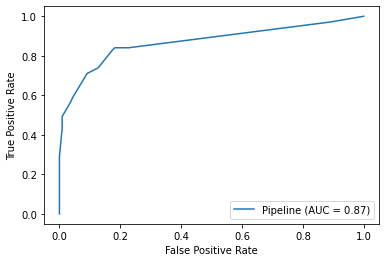

In [51]:
plot_roc_curve(model_default, X_test, y_test)

In [52]:
model_tuned = gridsearch.best_estimator_.fit(X_train_val, y_train_val)
y_pred_tuned = model_tuned.predict(X_test)

In [53]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       110
           1       0.71      0.67      0.69        69

    accuracy                           0.77       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.76      0.77      0.76       179



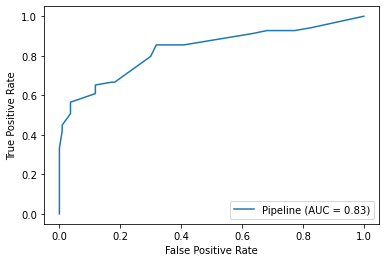

In [54]:
plot_roc_curve(model_tuned, X_test, y_test)

In [55]:
prob1 = model_default.predict_proba(X_test)[:,1]
fpr, tpr, thr = roc_curve(y_test, prob1)
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thr': thr})
roc_df

,fpr,tpr,thr
0,0.000000,0.000000,2.000000
1,0.000000,0.289855,1.000000
2,0.009091,0.434783,0.951923
3,0.009091,0.492754,0.928571
4,0.036364,0.565217,0.851351
5,0.045455,0.594203,0.700000
6,0.090909,0.710145,0.517857
7,0.127273,0.739130,0.411765
8,0.172727,0.826087,0.377358
9,0.181818,0.840580,0.333333


              precision    recall  f1-score   support

           0       0.89      0.82      0.85       110
           1       0.74      0.84      0.79        69

    accuracy                           0.83       179
   macro avg       0.82      0.83      0.82       179
weighted avg       0.83      0.83      0.83       179



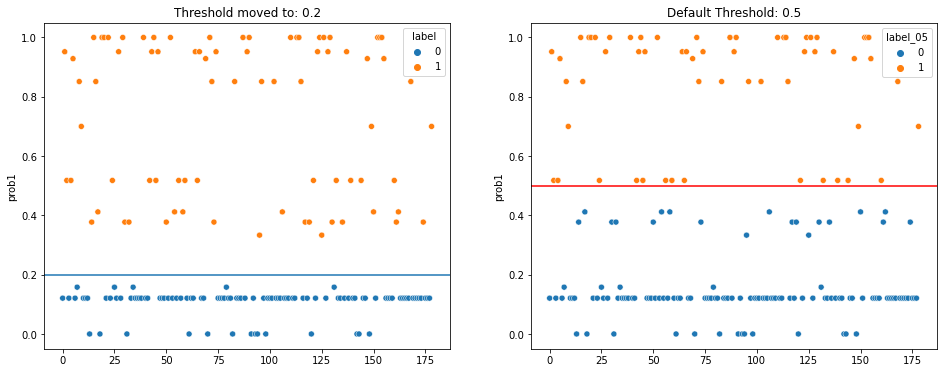

In [56]:
thr_move_to = 0.2
y_pred_thr = np.where(model_default.predict_proba(X_test)[:,1] > thr_move_to, 1, 0)
print(classification_report(y_test, y_pred_thr))

thr_test_df = pd.DataFrame(dict(zip(['label', 'prob1', 'label_05'], [y_pred_thr, model_default.predict_proba(X_test)[:,1], model_default.predict(X_test)])))
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title(f'Threshold moved to: {thr_move_to}')
sns.scatterplot(x=thr_test_df.index, y=thr_test_df['prob1'], hue=thr_test_df['label'])
plt.axhline(thr_move_to)

plt.subplot(122)
plt.title('Default Threshold: 0.5')
sns.scatterplot(x=thr_test_df.index, y=thr_test_df['prob1'], hue=thr_test_df['label_05'])
plt.axhline(0.5, color='red')

plt.show()

In [57]:
X_train_val.head()

,pclass,sex,age,sibsp,parch,fare,embarked,title
220,3,male,16.0,0,0,8.0500,S,Mr
325,1,female,36.0,0,0,135.6333,C,Miss
709,3,male,NaN,1,1,15.2458,C,Master
254,3,female,41.0,0,2,20.2125,S,Mrs
549,2,male,8.0,1,1,36.7500,S,Master


In [58]:
titanic[titanic['pclass'] == 1]['fare'].mean()

84.15468749999992

In [59]:
rose = [[1, 'female', 17, 1, 1, 85, 'S', 'Miss']]
model_default.predict(pd.DataFrame(rose, columns=X_train_val.columns))

array([1], dtype=int64)

In [60]:
jack = [[3, 'male', 20, 0, 0, 0, 'S', 'Mr']]
model_default.predict(pd.DataFrame(jack, columns=X_train_val.columns))

array([0], dtype=int64)